In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
import pickle
import numpy as np
import os

In [ ]:
file = open("Pride and Prejudice.txt", "r", encoding = "utf8")

# store file in list
lines = []
for i in file:
    lines.append(i)

# Convert list to string
data = ""
for i in lines:
  data = ' '. join(lines) 

#replace unnecessary stuff with space
data = data.replace('\n', '').replace('\r', '').replace('\ufeff', '').replace('“','').replace('”','')  #new line, carriage return, unicode character --> replace by space

#remove unnecessary spaces 
data = data.split()
data = ' '.join(data)
data[:500]



'The Project Gutenberg eBook of Pride and prejudice, by Jane Austen This eBook is for the use of anyone anywhere in the United States and most other parts of the world at no cost and with almost no restrictions whatsoever. You may copy it, give it away or re-use it under the terms of the Project Gutenberg License included with this eBook or online at www.gutenberg.org. If you are not located in the United States, you will have to check the laws of the country where you are located before using th'

In [ ]:
len(data)

737628

# **Apply tokenization**

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts([data])

# saving the tokenizer for predict function
pickle.dump(tokenizer, open('token.pkl', 'wb'))

sequence_data = tokenizer.texts_to_sequences([data])[0]
sequence_data[:15]

[1, 182, 164, 1001, 3, 299, 4, 946, 30, 72, 710, 41, 1001, 23, 21]

In [ ]:
len(sequence_data)

131237

In [ ]:
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)

7251


In [ ]:
sequences = []

for i in range(3, len(sequence_data)):
    words = sequence_data[i-3:i+1]
    sequences.append(words)
    
print("The Length of sequences are: ", len(sequences))
sequences = np.array(sequences)
sequences[:10]

The Length of sequences are:  131234


array([[   1,  182,  164, 1001],
       [ 182,  164, 1001,    3],
       [ 164, 1001,    3,  299],
       [1001,    3,  299,    4],
       [   3,  299,    4,  946],
       [ 299,    4,  946,   30],
       [   4,  946,   30,   72],
       [ 946,   30,   72,  710],
       [  30,   72,  710,   41],
       [  72,  710,   41, 1001]])

In [ ]:
X = []
y = []

for i in sequences:
    X.append(i[0:3])
    y.append(i[3])
    
X = np.array(X)
y = np.array(y)

In [ ]:
print("Data: ", X[:10])
print("Response: ", y[:10])

Data:  [[   1  182  164]
 [ 182  164 1001]
 [ 164 1001    3]
 [1001    3  299]
 [   3  299    4]
 [ 299    4  946]
 [   4  946   30]
 [ 946   30   72]
 [  30   72  710]
 [  72  710   41]]
Response:  [1001    3  299    4  946   30   72  710   41 1001]


In [ ]:
y = to_categorical(y, num_classes=vocab_size)
y[:5]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
model = Sequential()
model.add(Embedding(vocab_size, 10, input_length=3))
model.add(LSTM(1000, return_sequences=True))
model.add(LSTM(1000))
model.add(Dense(1000, activation="relu"))
model.add(Dense(vocab_size, activation="softmax"))

In [ ]:

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 3, 10)             72510     
                                                                 
 lstm (LSTM)                 (None, 3, 1000)           4044000   
                                                                 
 lstm_1 (LSTM)               (None, 1000)              8004000   
                                                                 
 dense (Dense)               (None, 1000)              1001000   
                                                                 
 dense_1 (Dense)             (None, 7251)              7258251   
                                                                 
Total params: 20,379,761
Trainable params: 20,379,761
Non-trainable params: 0
_________________________________________________________________


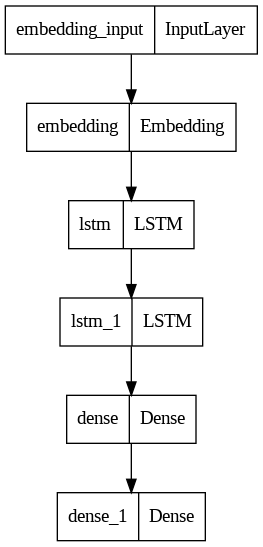

In [ ]:
from tensorflow import keras
from keras.utils.vis_utils import plot_model

keras.utils.plot_model(model, to_file='plot.png', show_layer_names=True)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint("next_words.h5", monitor='loss', verbose=1, save_best_only=True)
model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=0.001))
model.fit(X, y, epochs=70, batch_size=64, callbacks=[checkpoint])


Epoch 1/70
2051/2051 [==============================] - ETA: 0s - loss: 6.2245
Epoch 1: loss improved from inf to 6.22448, saving model to next_words.h5
2051/2051 [==============================] - 45s 17ms/step - loss: 6.2245
Epoch 2/70
2050/2051 [============================>.] - ETA: 0s - loss: 5.5836
Epoch 2: loss improved from 6.22448 to 5.58358, saving model to next_words.h5
2051/2051 [==============================] - 30s 15ms/step - loss: 5.5836
Epoch 3/70
2051/2051 [==============================] - ETA: 0s - loss: 5.2547
Epoch 3: loss improved from 5.58358 to 5.25466, saving model to next_words.h5
2051/2051 [==============================] - 31s 15ms/step - loss: 5.2547
Epoch 4/70
2051/2051 [==============================] - ETA: 0s - loss: 5.0211
Epoch 4: loss improved from 5.25466 to 5.02107, saving model to next_words.h5
2051/2051 [==============================] - 31s 15ms/step - loss: 5.0211
Epoch 5/70
2051/2051 [==============================] - ETA: 0s - loss: 4.8212
E

In [ ]:
from tensorflow.keras.models import load_model
import numpy as np
import pickle

# Load the model and tokenizer
model = load_model('next_words.h5')
tokenizer = pickle.load(open('token.pkl', 'rb'))

def Predict_Next_Words(model, tokenizer, text):

  sequence = tokenizer.texts_to_sequences([text])
  sequence = np.array(sequence)
  preds = np.argmax(model.predict(sequence))
  predicted_word = ""
  
  for key, value in tokenizer.word_index.items():
      if value == preds:
          predicted_word = key
          break
  
  print(predicted_word)
  return predicted_word

while(True):
  text = input("Enter your line: ")
  
  if text == "0":
      print("Execution completed.....")
      break
  
  else:
      try:
          text = text.split(" ")
          text = text[-3:]
          print(text)
        
          Predict_Next_Words(model, tokenizer, text)
          
      except Exception as e:
        print("Error occurred: ",e)
        continue

Enter your line: price and prejudice
['price', 'and', 'prejudice']
1/1 [==============================] - 1s 885ms/step
always
Enter your line: 0
Execution completed.....
